In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers
from tensorflow.keras import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [41]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2020-04-04 17:04:33--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-04-04 17:04:33 (104 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [42]:
# here I init all variable values for the model
dim = 100
LSTM_units1 = 150
LSTM_units2 = 100
dropout_rate = 0.2
hidden_layers = 120
output_layers = total_words
print("Total words: {}".format(total_words))
regularizers = regularizers.l2(l=0.01)
epochs = 33 
# epochs = 10 accuracy: 0.0434
# epochs = 33 accuracy: 0.2448
# would need up to 100 epochs to generate good accuracy
# with 5s per epoch would take this around 7,5 min

Total words: 3211


In [43]:
model = Sequential()
model.add(Embedding(total_words, dim, input_length = max_sequence_len-1))# Your Embedding Layer)
model.add(LSTM(units = LSTM_units1, return_sequences = True))# An LSTM Layer)
model.add(Dropout(rate = dropout_rate))# A dropout layer)
model.add(LSTM(units = LSTM_units2))# Another LSTM Layer)
model.add(Dense(units = total_words/2, 
                activation='relu', 
                kernel_regularizer = regularizers)) # A Dense Layer including regularizers)
model.add(Dense(units = output_layers, activation = "softmax"))# A Dense Layer)
# Pick an optimizer
model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])# Pick a loss function and an optimizer)
print(model.summary())


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 10, 100)           321100    
_________________________________________________________________
lstm_18 (LSTM)               (None, 10, 150)           150600    
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 150)           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 100)               100400    
_________________________________________________________________
dense_9 (Dense)              (None, 1605)              162105    
_________________________________________________________________
dense_10 (Dense)             (None, 3211)              5156866   
Total params: 5,891,071
Trainable params: 5,891,071
Non-trainable params: 0
___________________________________________

In [44]:
 history = model.fit(predictors, label, epochs=epochs, verbose=1)

Epoch 1/33
484/484 [==============================] - 5s 11ms/step - loss: 6.9346 - accuracy: 0.0230
Epoch 2/33
484/484 [==============================] - 6s 12ms/step - loss: 6.5164 - accuracy: 0.0215
Epoch 3/33
484/484 [==============================] - 5s 11ms/step - loss: 6.4161 - accuracy: 0.0217
Epoch 4/33
484/484 [==============================] - 5s 11ms/step - loss: 6.3285 - accuracy: 0.0294
Epoch 5/33
484/484 [==============================] - 6s 12ms/step - loss: 6.2137 - accuracy: 0.0343
Epoch 6/33
484/484 [==============================] - 6s 11ms/step - loss: 6.1198 - accuracy: 0.0389
Epoch 7/33
484/484 [==============================] - 5s 11ms/step - loss: 6.0257 - accuracy: 0.0404
Epoch 8/33
484/484 [==============================] - 5s 11ms/step - loss: 5.9479 - accuracy: 0.0432
Epoch 9/33
484/484 [==============================] - 5s 11ms/step - loss: 5.8672 - accuracy: 0.0444
Epoch 10/33
484/484 [==============================] - 5s 11ms/step - loss: 5.7807 - accura

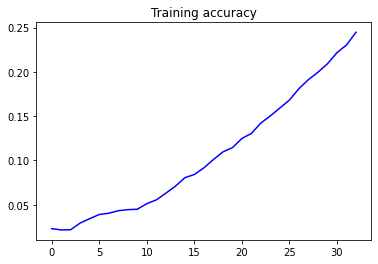

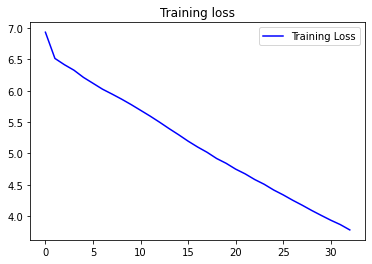

In [45]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [46]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 10
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Help me Obi Wan Kenobi, you're my only hope do you away prove forth cross days days shines so
